In [84]:
import pandas as pd
import numpy as np

dc_listings = pd.read_csv('dc_airbnb.csv')
print(dc_listings.iloc[0])

host_response_rate                  92%
host_acceptance_rate                91%
host_listings_count                  26
accommodates                          4
room_type               Entire home/apt
bedrooms                              1
bathrooms                             1
beds                                  2
price                           $160.00
cleaning_fee                    $115.00
security_deposit                $100.00
minimum_nights                        1
maximum_nights                     1125
number_of_reviews                     0
latitude                          38.89
longitude                      -77.0028
city                         Washington
zipcode                           20003
state                                DC
Name: 0, dtype: object


In [87]:
import warnings
warnings.filterwarnings("ignore")

dc_listings['price']=dc_listings['price'].apply(str)
stripped_commas = dc_listings['price'].str.replace(',', '') #remove commans
stripped_dollars = stripped_commas.str.replace('$', '') #remove dollar sign
dc_listings['price'] = stripped_dollars.astype('float') #convert to float
dc_listings=dc_listings.loc[np.random.permutation(len(dc_listings))] #randomply changes the order of rows
train_df = dc_listings.iloc[0:2792]
test_df = dc_listings.iloc[2792:]

def predict_price(new_listing):
    ## DataFrame.copy() performs a deep copy
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing)) #calculates the disatnce...
    #...of our listing with accommodates column in the dataset
    temp_df = temp_df.sort_values('distance') #sorts by distance
    nearest_neighbor_prices = temp_df.iloc[0:5]['price'] 
    predicted_price = nearest_neighbor_prices.mean() #gets the average of price among first five with least distances
    return(predicted_price)

test_df['predicted_price']=test_df['accommodates'].apply(lambda x: predict_price(x))

#now let's estimate the mean absolute error
test_df['abs_error'] = np.absolute(test_df['predicted_price'] - test_df['price'])
mae = test_df['abs_error'].mean()
print(mae)

#However, this does not show those predicted values that are way further away from the actual values.
#We can use Mean Squared Error instead, as it squares the magnitude of error.
test_df['sq_error'] = (test_df['predicted_price'] - test_df['price'])**2
mae = test_df['sq_error'].mean()
print(mae)

56.965628356605684
11970.823931256706


We can't really say whether the calculated MSE is actually low or high. In fact, the units of this error is dollar squared, which makes it even harder to interpret intuitively. What can we do is to fit another model and measure the MSE for that model and then compare. 

Let's fit a model based on number of bathrooms.

In [88]:
def predict_price(new_listing):
    ## DataFrame.copy() performs a deep copy
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['bathrooms'].apply(lambda x: np.abs(x - new_listing)) #calculates the disatnce...
    #...of our listing with bathrooms column in the dataset
    temp_df = temp_df.sort_values('distance') #sorts by distance
    nearest_neighbor_prices = temp_df.iloc[0:5]['price'] 
    predicted_price = nearest_neighbor_prices.mean() #gets the average of price among first five with least distances
    return(predicted_price)

test_df['predicted_price']=test_df['bathrooms'].apply(lambda x: predict_price(x))
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
mse = test_df['squared_error'].mean()
print(mse)

13990.16764769065


How about measuring the Root Mean Squared Error? it will be in the same units of our target variable.

In [89]:
rmse = mse ** (1/2)
print(rmse)

118.28003909236186


\$118 of error. This is too much, considering the listings are a couple of hundred dollars. There are two ways that we can achieve that goal:
* include more attributes
* increase k
Let's look at including more attributes. But first, we'd like to remove columns that are non-numerical, non-ordinal, and do not have anything to do with living space.

In [90]:
dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 1693 to 1857
Data columns (total 19 columns):
host_response_rate      3289 non-null object
host_acceptance_rate    3109 non-null object
host_listings_count     3723 non-null int64
accommodates            3723 non-null int64
room_type               3723 non-null object
bedrooms                3702 non-null float64
bathrooms               3696 non-null float64
beds                    3712 non-null float64
price                   3723 non-null float64
cleaning_fee            2335 non-null object
security_deposit        1426 non-null object
minimum_nights          3723 non-null int64
maximum_nights          3723 non-null int64
number_of_reviews       3723 non-null int64
latitude                3723 non-null float64
longitude               3723 non-null float64
city                    3723 non-null object
zipcode                 3714 non-null object
state                   3723 non-null object
dtypes: float64(6), int64(5), obje

Host response rate might have something to do with the price, if we knew how to uniquely group living spaces to the hosts, we could use this information. For now, we will drop it.
Zipcode, state, city, room_type are non numerical. Latitude and Longtitude are non-ordinal. We'll drop them as well.

In [91]:
drop_columns = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']
dc_listings_new = dc_listings.drop(drop_columns, axis=1)
print(dc_listings_new.shape[0])
print(dc_listings_new.isnull().sum())

3723
accommodates            0
bedrooms               21
bathrooms              27
beds                   11
price                   0
cleaning_fee         1388
security_deposit     2297
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


Number of missing values in bedrooms, bathrooms, and beds are trivial to overall observations. We can remove those rows.
For cleaning fee and security deposit, the number of missing values are substaintial. We can't remove the rows as we will lose so much information in our dataset. Hence, we simply remove those two columns.

In [92]:
dc_listings_new=dc_listings_new.drop(['cleaning_fee','security_deposit'],axis=1)

In [93]:
dc_listings_new=dc_listings_new.dropna(axis=0)
print(dc_listings_new.isnull().sum())

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


In [94]:
dc_listings_new.head()

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
1693,2,1.0,1.5,1.0,140.0,2,1125,20
2546,4,1.0,1.0,2.0,115.0,2,90,59
728,2,1.0,1.0,1.0,149.0,4,109,8
1297,3,1.0,1.0,1.0,130.0,1,1125,7
1194,3,0.0,1.0,2.0,129.0,4,365,26


Well, the range of maximum nights and number of reviews are much larger than other feastures. This will lead to potential outsize effect on calculating the error. Hence, let's normalize the values. How? using standard normal distribution. why? to also account for distribution of data and at the same time, normalize it.

x'=(x-mean)/sigma

In [95]:
normalized_listings = (dc_listings_new - dc_listings_new.mean())/(dc_listings_new.std())
#but we'd like for our target value to stay the same
normalized_listings['price'] = dc_listings_new['price']

### Model fitting
#### Impact of number of attributes on model accuracy
Now let's use Scikit-learn library for model fittiing

In [96]:
from sklearn.neighbors import KNeighborsRegressor #importing the class of K nearest neighbors
from sklearn.metrics import mean_squared_error #importing the mean squared error function

train_df = normalized_listings.iloc[0:2792] #75% trainiing set
test_df = normalized_listings.iloc[2792:]
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews'] #selecting our first batch of columns

knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean') #instatiating the class
knn.fit(train_df[features], train_df['price']) #fit gets a matrix-like and a list-like arguments.
predictions = knn.predict(test_df[features]) #predict takes the features of test dataset

two_features_mse = mean_squared_error(test_df['price'], predictions) #takes two vectors
two_features_rmse = two_features_mse ** (1/2)
print(two_features_mse)
print(two_features_rmse)

10727.8759954
103.575460392


In [97]:
# Now let's test if we'd take all features

features = train_df.columns.tolist()
features.remove('price')

knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute', metric='euclidean')
knn.fit(train_df[features], train_df['price'])
predictions = knn.predict(test_df[features])

two_features_mse = mean_squared_error(test_df['price'], predictions)
two_features_rmse = two_features_mse ** (1/2)
print(two_features_mse)
print(two_features_rmse)

11098.9878953
105.351734183


#### Summary so far
Adding more attributes generally decreasaes the model's error, and that is becuase the model looks for more similar observations to our case by looking at more attributes (and not just number of bedrooms per say). Also, we realized sometimes adding irrelavent attributes increases the error, so we should perform some "feature selection".

#### Impact of k value on model accuracy (hyperparameter optimization)
when we change the number features, we are changing the input data. Changing the k value keeps the data intact, and changes the behaviour of the model.

First let's comfirm the impact of k on model accuracy using a grid search approach.

In [98]:
#creating a subset of 5 values for k
hyper_parms=list(range(5))
hyper_parms=[x+1 for x in hyper_parms]

rmse=[]
for k in hyper_parms:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])

    two_features_mse = mean_squared_error(test_df['price'], predictions)
    two_features_rmse = two_features_mse ** (1/2)
    rmse.append(two_features_rmse)
rmse

[119.85618515309889,
 105.9873186653064,
 105.36669270571518,
 105.02973670147584,
 105.35173418285818]

Error is decreasing by increase in k

In [99]:
#now let's create a subet of 20
hyper_parms=[x for x in range(1,21)]

rmse=[]
for k in hyper_parms:
    knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute', metric='euclidean')
    knn.fit(train_df[features], train_df['price'])
    predictions = knn.predict(test_df[features])

    two_features_mse = mean_squared_error(test_df['price'], predictions)
    two_features_rmse = two_features_mse ** (1/2)
    rmse.append(two_features_rmse)
rmse

[119.85618515309889,
 105.9873186653064,
 105.36669270571518,
 105.02973670147584,
 105.35173418285818,
 103.9371345979205,
 102.58062742175066,
 102.05360921181081,
 103.21788390597581,
 101.73282392141765,
 102.04082067278486,
 102.00627093690758,
 102.33205154044087,
 102.27945894184569,
 102.54932215107173,
 102.05030826084452,
 101.91312801590448,
 101.83773326950454,
 101.88347093405439,
 101.89773769651515]

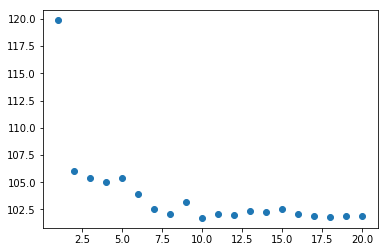

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(hyper_parms, rmse)

Therefore, as can be seen, the optimum value for k is 8.

#### Holdout validation
So far, we've been using train/test validation. Now we'd like to use holdout method. We divide dataset in two seperate equal size sets and swap train and test sets.

In [103]:
#shuffling the deck!
shuffled_index = np.random.permutation(dc_listings.index)
dc_listings = dc_listings.reindex(shuffled_index)

split_one = dc_listings.iloc[0:1862] #50% of dataset
split_two = dc_listings.iloc[1862:]

In [105]:
train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one

model=KNeighborsRegressor()
model.fit(train_one[["accommodates"]],train_one['price'])
test_one['predicted_price']=model.predict(test_one[['accommodates']])
rmse_one=mean_squared_error(test_one['price'],test_one['predicted_price'])**(1/2)

model.fit(train_two[["accommodates"]],train_two['price'])
test_two['predicted_price']=model.predict(test_two[['accommodates']])
rmse_two=mean_squared_error(test_two['price'],test_two['predicted_price'])**(1/2)

avg_rmse=(rmse_one+rmse_two)/2
avg_rmse

127.47882852165077

Holdout validation is a subset of k-fold corss validation process. In k-fold, we break the data set in k segments and repeat the train-test process across all segments by first training the model on k-1 segments, and then testing them out on the kth segment.

In [124]:
#here, we assign a fold value in a new column for each segment of dataset.
fold=int(normalized_listings.shape[0]/5)
for i in range(4):
    normalized_listings.set_value(normalized_listings.index[(i*fold):((i+1)*fold)],'fold',i+1)

normalized_listings.set_value(normalized_listings.index[4*fold:normalized_listings.shape[0]],'fold',5)
normalized_listings['fold'].value_counts()

5.0    735
4.0    734
3.0    734
2.0    734
1.0    734
Name: fold, dtype: int64

In [130]:
features=normalized_listings.columns.tolist()
features.remove('price')
rmse=[]
for fold in range(5):
    test_df=normalized_listings[dc_listings['fold']==fold+1]
    train_df=normalized_listings[normalized_listings['fold']!=fold+1]
    model=KNeighborsRegressor()
    model.fit(train_df[features],train_df['price'])
    predictions=model.predict(test_df[features])
    rmse.append(mean_squared_error(test_df['price'],predictions)**(1/2))

print('average error is: ', np.mean(rmse))

average error is:  108.642914877


Here's the takeaway so far:
* if we want to build a better k nearest neighbors model, we can use different features or alter k value.
* to test our model performance, we can use k fold cross validation and select the proper number of folds.

Next, we'd like to see how we can get advantage of Scikit learn libraries for handling corss-validation

In [132]:
from sklearn.model_selection import cross_val_score, KFold

kf=KFold(5,shuffle=True,random_state=1) #k=5, shuffles throw observations, and random seed is set to 1 for future iterations.
knn=KNeighborsRegressor()

#following function takes the estimator (here knn),tarining features, target value, scoring method, and number of folds...
#...number of folds (cv) can be a number or an instance of class KFold.
mses=cross_val_score(knn,normalized_listings[features],normalized_listings['price'],scoring="neg_mean_squared_error", cv=kf)
avg_rmse=np.mean((abs(mses))**(1/2))
print(avg_rmse)

114.080334234


Now let's calculate the error for different amount of k

In [136]:
folds=[(i+1)*3 for i in range(10)]
avg_rmse={}
for fold in folds:
    kf=KFold(fold,shuffle=True,random_state=1)
    knn=KNeighborsRegressor()
    mses=cross_val_score(knn,normalized_listings[features],normalized_listings['price'],scoring="neg_mean_squared_error", cv=kf)
    avg_rmse[fold]=np.mean((abs(mses))**(1/2))

avg_rmse

{3: 115.13480261235263,
 6: 113.85660874631708,
 9: 114.02915140765079,
 12: 112.4722332131816,
 15: 111.72909661296872,
 18: 111.2685466406412,
 21: 110.63619634098883,
 24: 108.70864199780188,
 27: 108.42046284960036,
 30: 107.90891439358008}